In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

import autograd.numpy as np
from autograd import grad 

# element-wise gradient is a standard-alone function in v1.2
from autograd import elementwise_grad as egrad

import autograd.numpy.random as npr
from autograd.misc.flatten import flatten_func, flatten

from scipy.integrate import solve_ivp # for comparision
from scipy.optimize import minimize
import numpy
import math

In [ ]:

# figure settings
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 13

In [ ]:
t0, tmax = [0, 2]

#y0_list = [1, 0] # rapid increase and then decay. Can't solve by NN!
y0_list = [2, -1] # simply decay. Can be solved by NN easily

In [ ]:
def f(t, y):
    '''
        dy/dt = f(t, y)
        This is f() function on the right
    '''    
    
    return [998*y[0] + 1998*y[1], -999*y[0] - 1999*y[1]]

# Build NN

In [ ]:
t = np.linspace(0, 5.0,10).reshape(-1,1) # training points

In [ ]:
def init_weights(n_in=1, n_hidden=10, n_out=1):
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params

params1 = init_weights()
params2 = init_weights()
params_list = [params1, params2]
print([ p.shape for p in params1 ])

[(1, 10), (10,), (10, 1), (1,)]


In [ ]:
def predict(params, t, y0, act=np.tanh):
    W1, b1, W2, b2 = params
    
    a = act(np.dot(t, W1) + b1)
    y = np.dot(a, W2) + b2
    
    phi = y0 + t*y
    
    return phi

In [ ]:
predict(params1, t, y0_list[1]).shape # vectorized over t

(10, 1)

In [ ]:
predict_dt = egrad(predict, argnum=1) # element-wise grad w.r.t t, 

In [ ]:
predict_dt(params1, t, y0_list[1]).shape

(10, 1)

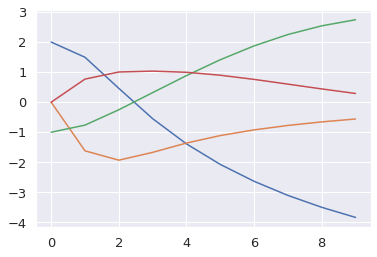

In [ ]:
plt.plot(predict(params1, t, y0_list[0]))
plt.plot(predict_dt(params1, t, y0_list[0]))
plt.plot(predict(params2, t, y0_list[1]))
plt.plot(predict_dt(params2, t, y0_list[1]))

In [ ]:
def loss_func(params_list, t, y0_list):
    
    
    y_pred_list = []
    dydt_pred_list = []
    for params, y0 in zip(params_list, y0_list):
        y_pred =  predict(params, t, y0)
        dydt_pred = predict_dt(params, t, y0)
        
        y_pred_list.append(y_pred)
        dydt_pred_list.append(dydt_pred)
        
    f_pred_list = f(t, y_pred_list)
    
    loss_total = 0.0
    for f_pred, dydt_pred in zip(f_pred_list, dydt_pred_list):
        loss = np.sum((dydt_pred-f_pred)**2)
        loss_total += loss
    #print("y_pred[0]",predict(params_list[0], t, y0_list[0]))
    return loss_total/(2*len(f_pred))

In [ ]:
loss_func(params_list, t, y0_list)

918740.2031640075

In [ ]:
flattened_params, unflat_func = flatten(params_list)

In [ ]:
def loss_part(flattened_params):
    '''make partial function. 
    Use this simple method because
    autograd or scipy does not like functool.partial'''
    
    params_list = unflat_func(flattened_params) # recover
    
    # warning: global t and y0 are used
    return loss_func(params_list, t, y0_list)

In [ ]:
loss_part(flattened_params)

918740.2031640075

In [ ]:
loss_part_grad = grad(loss_part)

In [ ]:
loss_part_grad(flattened_params).shape

(62,)

In [ ]:
%%time
count = 0
def print_loss(x):
    global count
    if count %200 == 0:  
        print("iteration:", count, "loss: ", loss_part(x))
    count += 1
        
o = minimize(loss_part, x0=flattened_params, jac=loss_part_grad, 
             method="BFGS", callback=print_loss, 
             options = {'gtol':0.0005,'disp': True, 'maxiter': 2000})

iteration: 0 loss:  730991.4915101675
iteration: 200 loss:  0.004222957070222492
iteration: 400 loss:  0.0006666029118634073
iteration: 600 loss:  3.4202565553695e-05
iteration: 800 loss:  1.514917404420036e-05
         Current function value: 0.000014
         Iterations: 912
         Function evaluations: 1062
         Gradient evaluations: 1050
CPU times: user 7.48 s, sys: 13 ms, total: 7.49 s
Wall time: 7.5 s


In [ ]:
loss_part(o.x)

1.3531395078354393e-05

In [ ]:
print(o.fun, o.njev, o.nfev, '\n', o.message)

1.3531395078354393e-05 1050 1062 
 Desired error not necessarily achieved due to precision loss.


In [ ]:
params1_opt, params2_opt = unflat_func(o.x)

In [ ]:
class RES:
  def __init__(self,t):
    self.t=t
    self.y=[[],[]]
    self.y[0]=[2*math.exp(-k) for k in t]
    self.y[1]=[-math.exp(-k) for k in t]
sol=RES(numpy.arange(0,5,5/12))


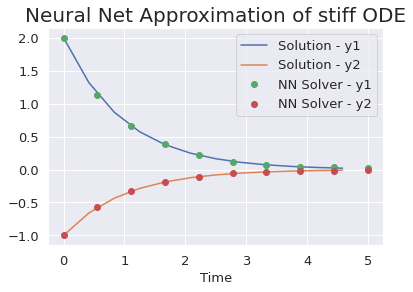

In [ ]:
plt.plot(sol.t, sol.y[0], label='Solution - y1')

plt.plot(sol.t, sol.y[1], label='Solution - y2')

plt.plot(t, predict(params1_opt, t, y0_list[0]), 'o', label='NN Solver - y1')
plt.plot(t, predict(params2_opt, t, y0_list[1]), 'o', label='NN Solver - y2')

plt.legend()
plt.title('Neural Net Approximation of stiff ODE')
plt.xlabel('Time')
plt.savefig("stiff_ANN.png", dpi=300)

In [ ]:
print(sol.t)
print(sol.y[1])

[0.         0.41666667 0.83333333 1.25       1.66666667 2.08333333
 2.5        2.91666667 3.33333333 3.75       4.16666667 4.58333333]
[-1.0, -0.6592406302004438, -0.4345982085070782, -0.2865047968601901, -0.18887560283756183, -0.12451447144412296, -0.0820849986238988, -0.05411376622282158, -0.035673993347252395, -0.023517745856009107, -0.015503853599009314, -0.010220770217146315]


Text(0.5, 1.0, 'dy/dt')

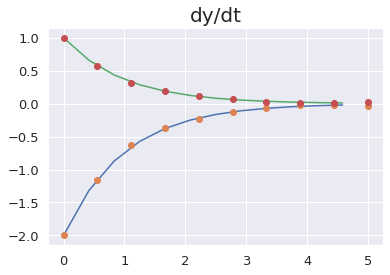

In [ ]:
dy=[[],[]]
for i in range(len(sol.t)):
  dy[0].append((f(sol.t,[sol.y[0][i],sol.y[1][i]])[0]))
  dy[1].append((f(sol.t,[sol.y[0][i],sol.y[1][i]])[1]))

plt.plot(sol.t, dy[0])
plt.plot(t, predict_dt(params1_opt, t, y0_list[0]), 'o')

plt.plot(sol.t, dy[1])
plt.plot(t, predict_dt(params2_opt, t, y0_list[1]), 'o')

plt.title('dy/dt')